<a href="https://colab.research.google.com/github/tcmb1987/ee259-project/blob/main/2D_DOA_DSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 361 and EE 259 Project - Radar Simulator with Optimizer


###Setup

Start with mounting your Stanford Google Drive.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Create Ubuntu toolchain, update and install latest libstdc++6 (what was giving us the headache before). Notice, after running the toolchain cell need to click below the prompt and hit 'Enter'. Also, install kaleido since it's what the tutorial uses for plotting.

In [ ]:
!add-apt-repository ppa:ubuntu-toolchain-r/test

 Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

 More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Press [ENTER] to continue or Ctrl-c to cancel adding it.

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu focal InRelease
Hit:12 http://ppa.launc

In [ ]:
!apt-get update
!apt-get upgrade
!apt-get install libstdc++6
!pip install kaleido

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntu-toolchain-r/test/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Calculating upgrade... D

Make sure path is correct, ensure the project folder is saved under 'MyDrive'.

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/EE_259_Project")

Import radarsimpy and test if successful by displaying version.

In [ ]:
import radarsimpy
radarsimpy.__version__

'11.1.0'

In [ ]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver
from radarsimpy.simulator import simpy
import plotly.graph_objs as go
from IPython.display import Image
from scipy import signal
import radarsimpy.processing as proc
from scipy.signal import find_peaks
from numpy.lib.function_base import average

## Radar Simulation
Based on the TDM FMCW MIMO [tutorial](https://radarsimx.com/2019/04/07/tdm-mimo-fmcw-radar/). In cell below, currently modifying parameters for TIDEP-01012 cascaded radar initial conditions. Setting up 12 TX antenna positions and characteristics (Thomas @ 6/1/2023 11:00 AM). Facing front of board, lower-left corner is origin. Characteristics referenced and measurements calculated using TIDEP-01012 [design guide](https://www.ti.com/lit/pdf/tiduen5).

In [ ]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

# TIDEP-01012 design parameters, use center of frequency range for our frequency
# tx parameters
frequency = 77e9
wavelength = 3e8 / frequency
theta_fov = 140
angular_res = 1.4
N = int(theta_fov//angular_res)
angle = np.linspace(-theta_fov/2, theta_fov/2, N)
tx_power = 45
pulses = 9
num_tx_channels = 9
num_rx_channels = 16
cycle_t = 32e-6
noise_level = 10
pulse_bw = 256e6
chirp_time = 17e-6
rep_period = 288e-6
rfgain = 20
bbgain = 50
res = 500

# rx parameters
samp_rate = 15e6
# Beam pattern definition (no changes from tutorial)
pattern = 20 * np.log10(np.cos(angle / 180 * np.pi) + 0.01) + 6

# PCB corner locations
PCB_corners = [[0, 0, 0],
               [0, 0, 34 * wavelength],
               [0, 40 * wavelength, 34 * wavelength],
               [0, 40 * wavelength, 0]]

Build radar simulator with initial conditions.

In [ ]:
#### 361 ADDITIONS ####
# There are 9 transmit, 16 receive, errbody on x = 0 plane
num_total_channels =  num_tx_channels + num_rx_channels
num_paths = num_tx_channels*num_rx_channels
allLocs = np.zeros((num_total_channels, 2))
# allLocs[:,0] = np.random.rand(25)*40*wavelength
# allLocs[:,1] = np.random.rand(25)*34*wavelength
allLocs[0,:] = np.array([30.5*wavelength, 11*wavelength])
allLocs[9,:] = np.array([7*wavelength, 30*wavelength])

# Define antenna locations for initial conditions according to TIDEP-01012
for i in range(1, num_tx_channels):
    allLocs[i,:] = np.array([allLocs[i-1,0] - 2*wavelength, allLocs[0,1]])
for i in range(num_tx_channels + 1, num_total_channels):
    if i == num_tx_channels + 6:
        allLocs[i,:] = np.array([allLocs[i-1,0] + 4*wavelength, allLocs[0,1]])
    elif i == num_tx_channels + 9:
        allLocs[i,:] = np.array([allLocs[i-1,0] + 16*wavelength, allLocs[0,1]])
    else:
        allLocs[i,:] = np.array([allLocs[i-1,0] + 0.5*wavelength, allLocs[0,1]])

# Build Transmitter
tx_channels = []
for i in range(num_tx_channels):
  tx_channels.append(dict(location=(0, allLocs[i,0], allLocs[i,1]),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern,
                    delay=i*cycle_t))

tx = Transmitter(f=[frequency, frequency+pulse_bw],
                 t=chirp_time,
                 tx_power=tx_power,
                 prp=rep_period,
                 pulses=pulses,
                 channels=tx_channels)

# Build Receiver
rx_channels = []
for i in range(num_tx_channels,num_total_channels):
  rx_channels.append(dict(location=(0, allLocs[i,0], allLocs[i,1]),
                    azimuth_angle=angle,
                    azimuth_pattern=pattern,
                    elevation_angle=angle,
                    elevation_pattern=pattern))

rx = Receiver(fs=samp_rate,
              noise_figure=noise_level,
              rf_gain=rfgain,
              baseband_gain=bbgain,
              load_resistor=res,
              channels=rx_channels)

radar = Radar(transmitter=tx, receiver=rx)

Build a target list.

In [ ]:
target_1 = dict(location=(160, 0, 0), speed=(0, 0, 0), rcs=25, phase=0)
target_2 = dict(location=(80, -80, 0), speed=(0, 0, 0), rcs=20, phase=0)
target_3 = dict(location=(30, 20, 0), speed=(0, 0, 0), rcs=8, phase=0)

targets = [target_1, target_2, target_3]

Initialize RadarSimPy Pythong engine. If this cell is not running, make sure the Setup section ran, then restart runtime, re-import radarsimpy and try running again.

In [ ]:
# Python engine
from radarsimpy.simulator import simpy

data = simpy(radar, targets)
timestamp = data['timestamp']
baseband = data['baseband']

In [ ]:
from scipy import signal
import radarsimpy.processing as proc

# DANA'S CHANGES WITH CFAR
range_window = signal.chebwin(radar.samples_per_pulse, at=60) # is 60 correct? example says 80?
doppler_window = signal.chebwin(tx.pulses, at=60) # is 60 correct?
range_dopp_prof = proc.range_doppler_fft(baseband, range_window,doppler_window)

P = range_dopp_prof.shape[0] # number of virtual elements
doppler_indices = range_dopp_prof.shape[1] # number of doppler indices (M)
range_indices = range_dopp_prof.shape[2] # number of range indices (N)

# initialize empty CFAR cube, same size as range-doppler processed cube
cfar_cube = np.empty((P,doppler_indices,range_indices))

# number of guard and training cells for CFAR
TARGET_GUARD = 50
TARGET_TRAINING = 100
DOA_GUARD = 30
DOA_TRAINING = 50

# TDM-MIMO phase compensation from Radar II slide 43
comp_range_dopp_prof = np.empty((P,doppler_indices,range_indices),dtype=complex)
for p in range(P):
  # compute tx element corresponding to this virtual array element
  k = p // num_rx_channels
  for l in range(doppler_indices):
    # doppler frequency?
    fdl = -l/(doppler_indices*num_tx_channels*chirp_time)
    for rn in range(range_indices):
      # multiply IF by exp(j*2*pi*fdl*k*T)
      comp_range_dopp_prof[p,l,rn] = range_dopp_prof[p,l,rn]*np.exp(1j*2*np.pi*fdl*k*chirp_time) # k, not k-1 bc of 0 indexing

# empty list of tuples of target indices
target_inds = []
# populate cfar cube by iterating over antennas, performing 2D cfar on that particular MxN doppler-range slice
for i in range(P):
  cfar_cube[i,:,:] = proc.cfar_ca_2d(range_dopp_prof[i,:,:],TARGET_GUARD,TARGET_TRAINING)

# initialize empty array to fill with rx signal about targets (like s vector from hw2q3)
s_vec = np.empty(P,dtype='complex128')
# iterate over every range and doppler index pair, get antenna element column
# compare cfar threshold column to corresponding IF data column to ensure that for given doppler-range indices, every element in the antenna column is greater than threshold
for di in range(doppler_indices):
  for ri in range(range_indices):
    # compare IF signal to CFAR threshold
    true_vec = range_dopp_prof[:,di,ri]>cfar_cube[:,di,ri]
    # if every IF cell > corresponding CFAR cell, add that range-doppler index to target list, add that IF signal to s vector
    if np.all(true_vec):
      target_inds.append((di,ri))
      s_vec += np.array(comp_range_dopp_prof[:,di,ri])

print("cfar 2d targets: "+str(target_inds))


# create theta (azimuth) and phi (elevation) search grids according to TIDEP angular resolutions
doa_fov = 140*np.pi/180
azimuth_res = 1.4#1.4 # degrees
elevation_res = 18 # degrees
# number of points is hard coded right now, since elevation angular resolution is too small
num_azimuth = 600#int(np.floor(140/azimuth_res))
num_elevation = 600#int(np.floor(140/elevation_res))
azimuth_grid = np.linspace(-doa_fov/2,doa_fov/2,num_azimuth) # theta
elevation_grid = np.linspace(-doa_fov/2,doa_fov/2,num_elevation) # phi

# initialize empty A matrix, like hw2q3
A = np.zeros((P,num_azimuth*num_elevation),dtype=complex)

# get positions of transmitters and receivers
# first 9 are tx, second 16 are rx
real_tx_pos = allLocs[:num_tx_channels]
real_rx_pos = allLocs[num_tx_channels:]

# initialize empty array to store virtual array element positions
virtual_array_elem_pos = np.empty((P,2))
idx = 0
# compute virtual array element positions
for tx_elem in range(num_tx_channels):
  for rx_elem in range(num_rx_channels):
    virtual_array_elem_pos[idx,:] = real_tx_pos[tx_elem]+real_rx_pos[rx_elem] # not
    idx += 1

# populate A matrix
# iterate over azimuth and elevation search grids and form columns of A according to Radar Part II, slides 33-36
idx = 0
for i in range(len(azimuth_grid)):
  for j in range(len(elevation_grid)):
      a_curr = np.array(np.exp(-2*1j*np.pi/wavelength*np.sin(azimuth_grid[i])*np.sin(elevation_grid[j])*np.array(virtual_array_elem_pos[:,0]))*np.exp(-2*1j*np.pi/wavelength*np.cos(elevation_grid[j])*np.array(virtual_array_elem_pos[:,1])))
      A[:,idx] = a_curr
      idx +=1

# measure closeness of s to different steering vectors by the norm of its projection onto the ai’s
d_multi = np.absolute(np.matmul(np.conjugate(np.transpose(A)),s_vec))


cfar 2d targets: [(1, 17), (1, 19), (8, 18)]


In [ ]:
# reshape d_multi into a num_theta x num_phi array in order to perform 2D CFAR
d_multi = np.reshape(d_multi,(num_azimuth,num_elevation))
# get corresponding threshold
doa_cfar = proc.cfar_ca_2d(d_multi,DOA_GUARD,DOA_TRAINING)
# find where data is greater than threshold
d_peaks = np.where(d_multi>doa_cfar)
#print("2d CFAR DOA peaks: "+str(d_peaks))
theta_hat= azimuth_grid[d_peaks[0]]*180/np.pi
print("theta_hat (degrees): "+str(theta_hat))
phi_hat= elevation_grid[d_peaks[1]]*180/np.pi
print("phi_hat (degrees): "+str(phi_hat))

theta_hat (degrees): [-70. -70. -70. ...  70.  70.  70.]
phi_hat (degrees): [-30.26711185 -30.03338898  -0.35058431 ...   0.35058431  30.03338898
  30.26711185]


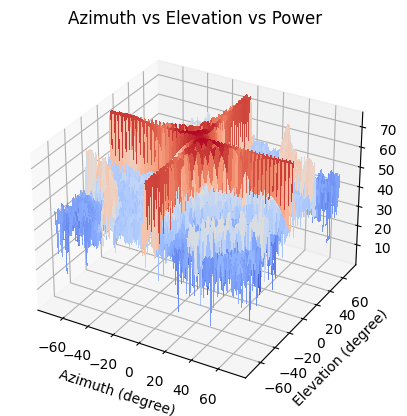

In [ ]:
# PLOT 2D theta vs phi map
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
d_multi = np.reshape(d_multi,(num_azimuth,num_elevation))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
Az, El = np.meshgrid(azimuth_grid*180/np.pi, elevation_grid*180/np.pi)
surf = ax.plot_surface(Az, El, 20*np.log10(np.transpose(d_multi)), cmap=cm.coolwarm,
linewidth=0, antialiased=False)
plt.title('Azimuth vs Elevation vs Power')
ax.set_xlabel('Azimuth (degree)')
ax.set_ylabel('Elevation (degree)')
ax.set_zlabel('Power (dB)')
plt.show()
